In [191]:
import xgboost as xgb
import matplotlib as matplot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gzip
from sklearn.pipeline import make_pipeline
import codecs
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate,GridSearchCV,train_test_split,RandomizedSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [131]:
df = pd.read_csv("centar_preprocessed.csv")
print("Centar shape: ",df.shape)
df['PM10'] = np.expm1(df['PM10'])

Centar shape:  (37412, 42)


In [132]:
y = df['PM10']
target = "PM10"
train = df.drop(['PM10','time'],axis=1)

In [138]:
def get_evaluation_splits():
    predict_window = 12
    df_evaluation = df.copy()
    df_evaluation["PM10"] = df["PM10"].shift(-predict_window)

    train_len = int(len(df_evaluation) - 2 * predict_window)
    train = df_evaluation[:train_len]
    final_eval = df_evaluation[-(2 * predict_window):-predict_window]

    X_train, y_train = train.drop(
            ["PM10","time"], axis=1), train["PM10"]
    X_final, y_final = final_eval.drop(
        ["PM10","time"], axis=1), final_eval["PM10"]
    
    return X_train,y_train,X_final,y_final

def evaluate_model(model,predictors):
    X_train,y_train,X_final,y_final = get_evaluation_splits()
    model.fit(X_train[predictors],y_train)
    predictions = model.predict(X_final[predictors])
    mae = mean_absolute_error(y_final, predictions)
    print("MAE score for model: ",mae)
    feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [146]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit='neg_mean_absolute_error'):
    gs = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2,
        random_state=42
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    pred = fitted_model.predict(X_test_data)
    return fitted_model, pred

MAE score for model:  8.329893986384073


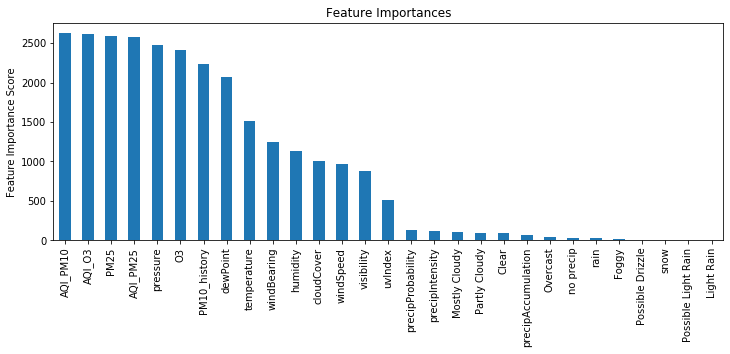

In [139]:
#FINDING NUM ESTIMATORS FOR HIGH LEARNING

predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBRegressor(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        booster='gbtree',
        njobs=-1,
        colsample_bytree=0.8,
        seed=27)
evaluate_model(xgb1,predictors)

In [148]:
best_n_estimators_1 = 1000
param_grid = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
estimator = XGBRegressor(
        learning_rate =0.1,
        n_estimators=best_n_estimators_1,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        n_jobs=-1,
        colsample_bytree=0.8,
        random_state=42)

X_train,y_train,X_test,y_test = get_evaluation_splits()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, estimator, 
                                 param_grid)

# Root Mean Squared Error
print("MAE best score: ",-model.best_score_)
print("MAE regular: ",mean_absolute_error(y_test,pred))
print("Best params: ",model.best_params_)
results = pd.DataFrame(model.cv_results_)
results

MAE best score:  23.64844737693598
MAE regular:  8.058605273564657
Best params:  {'min_child_weight': 1, 'max_depth': 3}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,141.708105,0.692881,1.013658,0.087021,3,9,"{'min_child_weight': 3, 'max_depth': 9}",-28.345465,-30.352578,-18.657508,-21.866098,-24.615925,-24.767596,4.237256,5
1,141.703105,0.553249,1.114464,0.165479,1,9,"{'min_child_weight': 1, 'max_depth': 9}",-28.351963,-30.418186,-18.456531,-21.895110,-23.718032,-24.568059,4.330447,4
2,54.708329,0.111149,0.174810,0.002482,1,3,"{'min_child_weight': 1, 'max_depth': 3}",-29.018818,-30.799192,-17.509702,-21.176697,-19.736974,-23.648447,5.273935,1
3,109.747477,0.652376,0.570033,0.011064,5,7,"{'min_child_weight': 5, 'max_depth': 7}",-28.791350,-31.734360,-18.689872,-21.792717,-25.407876,-25.283325,4.681876,10
4,81.829280,1.294951,0.347620,0.015501,5,5,"{'min_child_weight': 5, 'max_depth': 5}",-28.604656,-32.303124,-18.375208,-21.994110,-23.540357,-24.963608,4.927096,8
5,58.629153,3.599356,0.181010,0.003347,5,3,"{'min_child_weight': 5, 'max_depth': 3}",-28.919783,-31.098406,-17.696808,-21.349864,-19.683690,-23.749883,5.285204,2
6,56.820850,2.617714,0.177410,0.002728,3,3,"{'min_child_weight': 3, 'max_depth': 3}",-29.031103,-32.080136,-17.740656,-21.200139,-19.600873,-23.930770,5.602719,3
7,140.304225,1.336001,0.907452,0.023020,5,9,"{'min_child_weight': 5, 'max_depth': 9}",-28.052894,-31.672127,-18.588760,-21.855080,-24.182815,-24.870434,4.591733,6
8,86.212931,6.703987,0.355020,0.010734,3,5,"{'min_child_weight': 3, 'max_depth': 5}",-28.843684,-32.925184,-18.441557,-21.697403,-22.468333,-24.875381,5.250515,7
9,113.846712,1.376301,0.634636,0.090171,3,7,"{'min_child_weight': 3, 'max_depth': 7}",-28.469611,-30.738968,-18.744901,-22.083915,-25.018201,-25.011197,4.303656,9


In [151]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[0.5,1,2]
}
estimator = XGBRegressor(
        learning_rate =0.1,
        n_estimators=best_n_estimators_1,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        n_jobs=-1,
        colsample_bytree=0.8,
        random_state=42)

X_train,y_train,X_test,y_test = get_evaluation_splits()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, estimator, 
                                 param_test2)

# Root Mean Squared Error
print("MAE best score: ",-model.best_score_)
print("MAE regular: ",mean_absolute_error(y_test,pred))
print("Best params: ",model.best_params_)
results = pd.DataFrame(model.cv_results_)
results

F:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 11.9min finished


MAE best score:  23.15783890685888
MAE regular:  5.6251672705014535
Best params:  {'min_child_weight': 0.5, 'max_depth': 2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,45.821821,3.453418,0.119807,0.001600,0.5,2,"{'min_child_weight': 0.5, 'max_depth': 2}",-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
1,47.129296,2.073817,0.133008,0.008556,1,2,"{'min_child_weight': 1, 'max_depth': 2}",-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
2,49.385425,1.871452,0.131608,0.006249,2,2,"{'min_child_weight': 2, 'max_depth': 2}",-28.679337,-29.986746,-17.270486,-21.143742,-19.090387,-23.234306,5.145049,3
3,61.040891,2.786082,0.184811,0.008281,0.5,3,"{'min_child_weight': 0.5, 'max_depth': 3}",-29.018818,-30.799192,-17.509702,-21.176697,-19.736974,-23.648447,5.273935,4
4,59.776619,2.192205,0.194611,0.006407,1,3,"{'min_child_weight': 1, 'max_depth': 3}",-29.018818,-30.799192,-17.509702,-21.176697,-19.736974,-23.648447,5.273935,4
5,61.430114,3.126433,0.191811,0.008796,2,3,"{'min_child_weight': 2, 'max_depth': 3}",-29.216801,-31.200699,-17.685972,-21.251184,-19.892680,-23.849642,5.352559,6
6,73.664213,2.912449,0.266615,0.016428,0.5,4,"{'min_child_weight': 0.5, 'max_depth': 4}",-28.649518,-32.648578,-17.958979,-21.671463,-22.067972,-24.599448,5.296685,7
7,76.965402,3.672574,0.308218,0.042190,1,4,"{'min_child_weight': 1, 'max_depth': 4}",-28.649518,-32.648578,-17.958979,-21.671463,-22.067972,-24.599448,5.296685,7
8,73.775420,1.423909,0.266215,0.013076,2,4,"{'min_child_weight': 2, 'max_depth': 4}",-28.929153,-32.425975,-18.128106,-21.617953,-22.789136,-24.778202,5.174775,9


In [154]:
max_depth_best_1=3
min_child_weight_best=0.5
param_test3 = {
 'min_child_weight':[0.5,0.25,0.75],
 'max_depth':[2,8,10,12]
}
estimator = XGBRegressor(
        learning_rate =0.1,
        n_estimators=best_n_estimators_1,
        max_depth=max_depth_best_1,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        n_jobs=-1,
        colsample_bytree=0.8,
        random_state=42)

X_train,y_train,X_test,y_test = get_evaluation_splits()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, estimator, 
                                 param_test3)

# Root Mean Squared Error
print("MAE best score: ",-model.best_score_)
print("MAE regular: ",mean_absolute_error(y_test,pred))
print("Best params: ",model.best_params_)
results = pd.DataFrame(model.cv_results_)
results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 28.8min finished


MAE best score:  23.15783890685888
MAE regular:  5.6251672705014535
Best params:  {'min_child_weight': 0.5, 'max_depth': 2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,208.609532,8.577321,2.278130,0.381799,0.25,12,"{'min_child_weight': 0.25, 'max_depth': 12}",-28.442560,-29.477263,-18.424859,-21.712392,-22.902268,-24.191969,4.173168,4
1,202.786999,8.353920,1.993314,0.282565,0.5,12,"{'min_child_weight': 0.5, 'max_depth': 12}",-28.442560,-29.477263,-18.424859,-21.712392,-22.902268,-24.191969,4.173168,4
2,43.043062,0.204899,0.129607,0.012468,0.5,2,"{'min_child_weight': 0.5, 'max_depth': 2}",-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
3,160.088556,0.804583,1.091262,0.005845,0.75,10,"{'min_child_weight': 0.75, 'max_depth': 10}",-28.394305,-30.296622,-18.445941,-22.103061,-24.453246,-24.738713,4.263444,7
4,127.588698,0.837705,0.825647,0.015820,0.75,8,"{'min_child_weight': 0.75, 'max_depth': 8}",-28.751158,-31.175433,-18.669048,-21.837928,-24.313457,-24.949505,4.533200,9
5,43.370881,0.310705,0.120007,0.001549,0.75,2,"{'min_child_weight': 0.75, 'max_depth': 2}",-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
6,43.227272,0.192300,0.121007,0.001789,0.25,2,"{'min_child_weight': 0.25, 'max_depth': 2}",-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
7,196.223823,2.346527,1.913510,0.079010,0.75,12,"{'min_child_weight': 0.75, 'max_depth': 12}",-28.442560,-29.477263,-18.424859,-21.712392,-22.902268,-24.191969,4.173168,4
8,137.545067,7.120811,0.873050,0.108393,0.25,8,"{'min_child_weight': 0.25, 'max_depth': 8}",-28.751158,-31.175433,-18.669048,-21.837928,-24.313457,-24.949505,4.533200,9
9,162.671504,3.356905,1.099863,0.058939,0.25,10,"{'min_child_weight': 0.25, 'max_depth': 10}",-28.394305,-30.296622,-18.445941,-22.103061,-24.453246,-24.738713,4.263444,7


In [156]:
param_test4 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
estimator = XGBRegressor(
        learning_rate =0.1,
        n_estimators=best_n_estimators_1,
        max_depth=2,
        min_child_weight=0.5,
        gamma=0,
        subsample=0.8,
        n_jobs=-1,
        colsample_bytree=0.8,
        random_state=42)

X_train,y_train,X_test,y_test = get_evaluation_splits()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, estimator, 
                                 param_test4)

# Root Mean Squared Error
print("MAE best score: ",-model.best_score_)
print("MAE regular: ",mean_absolute_error(y_test,pred))
print("Best params: ",model.best_params_)
results = pd.DataFrame(model.cv_results_)
results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.0min finished


MAE best score:  23.15783890685888
MAE regular:  5.6251672705014535
Best params:  {'gamma': 0.0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,42.963457,0.096001,0.120207,0.001939,0,{'gamma': 0.0},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
1,42.819649,0.196587,0.120007,0.002450,0.1,{'gamma': 0.1},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
2,43.127267,0.195843,0.120607,0.001357,0.2,{'gamma': 0.2},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
3,42.875252,0.375257,0.119407,0.001020,0.3,{'gamma': 0.3},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
4,42.434227,0.505571,0.122407,0.008755,0.4,{'gamma': 0.4},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1


In [157]:
param_test5 = {
 'gamma':[i/100.0 for i in range(0,100,10)]
}
estimator = XGBRegressor(
        learning_rate =0.1,
        n_estimators=best_n_estimators_1,
        max_depth=2,
        min_child_weight=0.5,
        gamma=0,
        subsample=0.8,
        n_jobs=-1,
        colsample_bytree=0.8,
        random_state=42)

X_train,y_train,X_test,y_test = get_evaluation_splits()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, estimator, 
                                 param_test5)

# Root Mean Squared Error
print("MAE best score: ",-model.best_score_)
print("MAE regular: ",mean_absolute_error(y_test,pred))
print("Best params: ",model.best_params_)
results = pd.DataFrame(model.cv_results_)
results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.3min finished


MAE best score:  23.15783890685888
MAE regular:  5.6251672705014535
Best params:  {'gamma': 0.0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,42.852651,0.144313,0.120007,0.003406,0,{'gamma': 0.0},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
1,42.796248,0.144166,0.123607,0.008823,0.1,{'gamma': 0.1},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
2,42.680041,0.081022,0.119607,0.000490,0.2,{'gamma': 0.2},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
3,42.685642,0.056329,0.120007,0.004858,0.3,{'gamma': 0.3},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
4,42.701242,0.051568,0.118207,0.002040,0.4,{'gamma': 0.4},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
5,42.724844,0.095419,0.118207,0.001470,0.5,{'gamma': 0.5},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
6,42.809649,0.154436,0.127407,0.017317,0.6,{'gamma': 0.6},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
7,42.758446,0.188208,0.118807,0.001721,0.7,{'gamma': 0.7},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
8,42.686042,0.070228,0.118607,0.002577,0.8,{'gamma': 0.8},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1
9,42.404225,0.501995,0.117407,0.001497,0.9,{'gamma': 0.9},-28.668579,-29.754075,-17.139732,-21.109542,-19.116451,-23.157839,5.111336,1


In [158]:
param_test6 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
estimator = XGBRegressor(
        learning_rate =0.1,
        n_estimators=best_n_estimators_1,
        max_depth=2,
        min_child_weight=0.5,
        gamma=0,
        subsample=0.8,
        n_jobs=-1,
        colsample_bytree=0.8,
        random_state=42)

X_train,y_train,X_test,y_test = get_evaluation_splits()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, estimator, 
                                 param_test6)

# Root Mean Squared Error
print("MAE best score: ",-model.best_score_)
print("MAE regular: ",mean_absolute_error(y_test,pred))
print("Best params: ",model.best_params_)
results = pd.DataFrame(model.cv_results_)
results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.1min finished


MAE best score:  23.07657677657708
MAE regular:  6.046934564908344
Best params:  {'subsample': 0.9, 'colsample_bytree': 0.8}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,37.656954,0.108806,0.117807,0.002638,0.6,0.6,"{'subsample': 0.6, 'colsample_bytree': 0.6}",-28.669301,-30.281318,-17.248411,-21.272403,-18.975549,-23.289565,5.234609,8
1,37.725958,0.386163,0.118607,0.002653,0.7,0.6,"{'subsample': 0.7, 'colsample_bytree': 0.6}",-28.552206,-29.840166,-17.259416,-21.192833,-19.173205,-23.203727,5.065103,5
2,40.110694,0.085125,0.117807,0.001327,0.7,0.7,"{'subsample': 0.7, 'colsample_bytree': 0.7}",-28.845961,-30.010706,-17.296950,-21.152977,-19.499073,-23.361296,5.116059,10
3,45.291790,0.125566,0.117807,0.002315,0.8,0.9,"{'subsample': 0.8, 'colsample_bytree': 0.9}",-28.568706,-29.688745,-17.189350,-21.157220,-19.364103,-23.193782,5.018880,4
4,45.344394,0.019733,0.137408,0.039370,0.7,0.9,"{'subsample': 0.7, 'colsample_bytree': 0.9}",-28.816297,-29.552213,-17.418621,-21.190544,-19.475990,-23.290891,4.963604,9
5,42.647439,0.114947,0.119807,0.001939,0.9,0.8,"{'subsample': 0.9, 'colsample_bytree': 0.8}",-28.712535,-29.108291,-17.067292,-21.183151,-19.310858,-23.076577,4.940181,1
6,42.786247,0.108142,0.115607,0.003200,0.6,0.8,"{'subsample': 0.6, 'colsample_bytree': 0.8}",-28.703647,-29.995216,-17.229467,-21.266639,-19.061067,-23.251372,5.156979,7
7,42.859251,0.207844,0.118007,0.001414,0.7,0.8,"{'subsample': 0.7, 'colsample_bytree': 0.8}",-28.709160,-29.917556,-17.078899,-21.179485,-19.236738,-23.224529,5.152391,6
8,37.521146,0.103238,0.119207,0.002040,0.8,0.6,"{'subsample': 0.8, 'colsample_bytree': 0.6}",-28.645676,-29.706050,-17.145495,-21.177260,-18.999482,-23.134956,5.106072,2
9,44.916369,0.389407,0.120207,0.003544,0.9,0.9,"{'subsample': 0.9, 'colsample_bytree': 0.9}",-28.552105,-29.729514,-17.096024,-21.411863,-19.071610,-23.172380,5.075027,3


In [160]:
param_test7 = {
 'subsample':[i/100.0 for i in range(55,96,5)],
 'colsample_bytree':[i/100.0 for i in range(55,96,5)]
}
estimator = XGBRegressor(
        learning_rate =0.1,
        n_estimators=best_n_estimators_1,
        max_depth=2,
        min_child_weight=0.5,
        gamma=0,
        subsample=0.8,
        n_jobs=-1,
        colsample_bytree=0.8,
        random_state=42)

X_train,y_train,X_test,y_test = get_evaluation_splits()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, estimator, 
                                 param_test7)

# Root Mean Squared Error
print("MAE best score: ",-model.best_score_)
print("MAE regular: ",mean_absolute_error(y_test,pred))
print("Best params: ",model.best_params_)
results = pd.DataFrame(model.cv_results_)
results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.5min finished


MAE best score:  23.172380055148007
MAE regular:  5.623965462048847
Best params:  {'subsample': 0.9, 'colsample_bytree': 0.9}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,40.711729,0.700078,0.120407,0.002654,0.7,0.7,"{'subsample': 0.7, 'colsample_bytree': 0.7}",-28.845961,-30.010706,-17.296950,-21.152977,-19.499073,-23.361296,5.116059,8
1,36.461885,0.059365,0.119007,0.002450,0.55,0.55,"{'subsample': 0.55, 'colsample_bytree': 0.55}",-28.547297,-30.380481,-17.417197,-21.125200,-19.131642,-23.320534,5.184242,7
2,39.147839,0.479202,0.119607,0.002245,0.75,0.65,"{'subsample': 0.75, 'colsample_bytree': 0.65}",-28.649755,-30.855148,-17.062368,-21.225347,-19.161674,-23.391029,5.403733,9
3,40.317306,0.099176,0.119807,0.002400,0.75,0.7,"{'subsample': 0.75, 'colsample_bytree': 0.7}",-28.803347,-30.118582,-17.233617,-21.089706,-19.280210,-23.305259,5.189013,5
4,39.051834,0.112865,0.118807,0.003655,0.55,0.65,"{'subsample': 0.55, 'colsample_bytree': 0.65}",-28.642717,-29.585499,-17.530026,-21.124210,-19.196695,-23.215993,4.957505,3
5,40.424112,0.148710,0.117407,0.002939,0.6,0.7,"{'subsample': 0.6, 'colsample_bytree': 0.7}",-28.601473,-30.086402,-17.265075,-21.387107,-19.246460,-23.317464,5.112227,6
6,37.865166,0.099864,0.123607,0.015731,0.6,0.6,"{'subsample': 0.6, 'colsample_bytree': 0.6}",-28.669301,-30.281318,-17.248411,-21.272403,-18.975549,-23.289565,5.234609,4
7,45.443199,0.110095,0.122807,0.003868,0.9,0.9,"{'subsample': 0.9, 'colsample_bytree': 0.9}",-28.552105,-29.729514,-17.096024,-21.411863,-19.071610,-23.172380,5.075027,1
8,36.493687,0.181884,0.121207,0.003430,0.75,0.55,"{'subsample': 0.75, 'colsample_bytree': 0.55}",-28.683537,-30.828578,-17.286220,-21.128240,-19.187412,-23.422972,5.355121,10
9,37.494145,0.377150,0.117407,0.002871,0.7,0.6,"{'subsample': 0.7, 'colsample_bytree': 0.6}",-28.552206,-29.840166,-17.259416,-21.192833,-19.173205,-23.203727,5.065103,2


In [163]:
param_test8 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 0.5,1,5,10, 100]
}
estimator = XGBRegressor(
        learning_rate =0.1,
        n_estimators=best_n_estimators_1,
        max_depth=2,
        min_child_weight=0.5,
        gamma=0,
        subsample=0.9,
        n_jobs=-1,
        colsample_bytree=0.9,
        random_state=42)

X_train,y_train,X_test,y_test = get_evaluation_splits()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, estimator, 
                                 param_test8)

# Root Mean Squared Error
print("MAE best score: ",-model.best_score_)
print("MAE regular: ",mean_absolute_error(y_test,pred))
print("Best params: ",model.best_params_)
results = pd.DataFrame(model.cv_results_)
results

F:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.6min finished


MAE best score:  23.049843245357085
MAE regular:  6.95161493619283
Best params:  {'reg_alpha': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,45.555006,0.213063,0.125807,0.006178,1e-05,{'reg_alpha': 1e-05},-28.552106,-29.729515,-17.096024,-21.411862,-19.071610,-23.172380,5.075028,2
1,45.232787,0.130862,0.120807,0.003311,0.01,{'reg_alpha': 0.01},-28.554756,-29.729489,-17.096022,-21.411857,-19.071609,-23.172903,5.075584,3
2,45.484202,0.232006,0.121607,0.002332,0.1,{'reg_alpha': 0.1},-28.554633,-30.324424,-17.162404,-21.354472,-19.071415,-23.293635,5.220996,7
3,45.590007,0.112351,0.123007,0.003162,0.5,{'reg_alpha': 0.5},-28.604712,-29.856005,-17.118189,-21.439924,-19.132010,-23.230325,5.101919,6
4,45.872224,0.241007,0.120807,0.002040,1,{'reg_alpha': 1},-28.575807,-29.810240,-17.215465,-21.347577,-19.172224,-23.224421,5.060927,5
5,45.630010,0.230732,0.121207,0.001470,5,{'reg_alpha': 5},-28.730978,-29.981231,-17.179835,-21.331846,-19.336533,-23.312244,5.122053,8
6,45.573407,0.262407,0.123207,0.002136,10,{'reg_alpha': 10},-28.555240,-29.641095,-17.135391,-21.385676,-19.312079,-23.206049,5.007146,4
7,45.577807,0.145844,0.121807,0.003371,100,{'reg_alpha': 100},-28.701648,-28.802880,-17.343811,-21.230753,-19.169361,-23.049843,4.816017,1


In [166]:
param_test8 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 0.5,1,5,10, 100]
}
estimator = XGBRegressor(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=2,
        min_child_weight=0.5,
        gamma=0,
        subsample=0.9,
        n_jobs=-1,
        colsample_bytree=0.9,
        reg_alpha=0.01,
        random_state=42)

X_train,y_train,X_test,y_test = get_evaluation_splits()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, estimator, 
                                 param_test8)

# Root Mean Squared Error
print("MAE best score: ",-model.best_score_)
print("MAE regular: ",mean_absolute_error(y_test,pred))
print("Best params: ",model.best_params_)
results = pd.DataFrame(model.cv_results_)
results

F:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.6min finished


MAE best score:  22.56236091697391
MAE regular:  6.633733669916789
Best params:  {'reg_lambda': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,45.700214,0.385310,0.120407,0.002245,1e-05,{'reg_lambda': 1e-05},-28.762461,-29.740717,-17.221824,-21.384143,-19.311311,-23.284248,5.056653,7
1,45.292391,0.243205,0.129207,0.013674,0.01,{'reg_lambda': 0.01},-28.838737,-29.187887,-17.164879,-21.380014,-19.370493,-23.188553,4.940724,5
2,45.311992,0.179354,0.121007,0.001095,0.1,{'reg_lambda': 0.1},-28.662182,-29.897873,-17.208915,-21.391101,-19.347181,-23.301607,5.072656,8
3,45.496202,0.266007,0.121407,0.002653,0.5,{'reg_lambda': 0.5},-28.596536,-30.042428,-17.217988,-21.205360,-19.225291,-23.257684,5.128168,6
4,45.530604,0.189858,0.122007,0.003688,1,{'reg_lambda': 1},-28.554756,-29.729489,-17.096022,-21.411857,-19.071609,-23.172903,5.075584,4
5,45.395796,0.241827,0.122007,0.002608,5,{'reg_lambda': 5},-28.602481,-29.324453,-17.173026,-21.278032,-19.326938,-23.141138,4.933587,3
6,45.266989,0.095476,0.120807,0.002638,10,{'reg_lambda': 10},-28.484249,-29.097556,-17.200880,-21.119169,-19.069553,-22.994437,4.896460,2
7,45.191985,0.186310,0.123807,0.003060,100,{'reg_lambda': 100},-28.429836,-27.167255,-17.183463,-20.920282,-19.110286,-22.562361,4.453795,1
